In [86]:
import numpy as np
from astropy.io import fits
from astropy.visualization import make_lupton_rgb, simple_norm
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from pathlib import Path

In [87]:
files = {
    'F435W': 'cluster_img/abell2744/hlsp_frontier_hst_acs-60mas_abell2744_f435w_v1.0-epoch2_drz.fits',
    'F606W': 'cluster_img/abell2744/hlsp_frontier_hst_acs-60mas_abell2744_f606w_v1.0-epoch2_drz.fits',
    'F814W': 'cluster_img/abell2744/hlsp_frontier_hst_acs-60mas_abell2744_f814w_v1.0-epoch2_drz.fits',
    'F105W': 'cluster_img/abell2744/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits',
    'F125W': 'cluster_img/abell2744/hlsp_frontier_hst_wfc3-60mas_abell2744_f125w_v1.0_drz.fits',
    'F140W': 'cluster_img/abell2744/hlsp_frontier_hst_wfc3-60mas_abell2744_f140w_v1.0_drz.fits',
    'F160W': 'cluster_img/abell2744/hlsp_frontier_hst_wfc3-60mas_abell2744_f160w_v1.0_drz.fits'
}

In [88]:
def read(f):                                  # helper
    return fits.getdata(f, 0, memmap=True)

b435, b606 = read(files['F435W']), read(files['F606W'])
g814, g105 = read(files['F814W']), read(files['F105W'])
r125 = read(files['F125W'])
r140 = read(files['F140W'])
r160 = read(files['F160W'])

In [89]:
# ------------------------------------------------------------------
# 3) build each colour channel -------------------------------------
# simple equal-weight average works well; tweak the weights if you
# want a bluer/ redder balance
blue  = (b435 + b606) / 2.0
green = (g814 + g105) / 2.0
red   = (r125 + r140 + r160) / 3.0
blue  *= 1.00   # brighten faint blue arcs
green *= 1.10
red   *= 1.10   # hold down IR-bright members

# optional: rescale each plane to the same percentile range so no
# single filter dominates
for plane in (blue, green, red):
    p1, p99 = np.percentile(plane, (1, 99.5))
    plane[:] = np.clip((plane - p1) / (p99 - p1), 0, 1)

In [90]:
rgb = make_lupton_rgb(red, green, blue, Q=10, stretch=0.5)  # experiment with Q & stretch

/home/dices/.venv/lib/python3.12/site-packages/astropy/visualization/lupton_rgb.py:614: RuntimeWarning: invalid value encountered in divide
  fInorm = np.where(Int <= 0, 0, np.true_divide(fI, Int))


/tmp/ipykernel_60675/2916572624.py:58: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_rot, y_rot, s=60, c='yellow', marker='x', ec='black', lw=0.5)


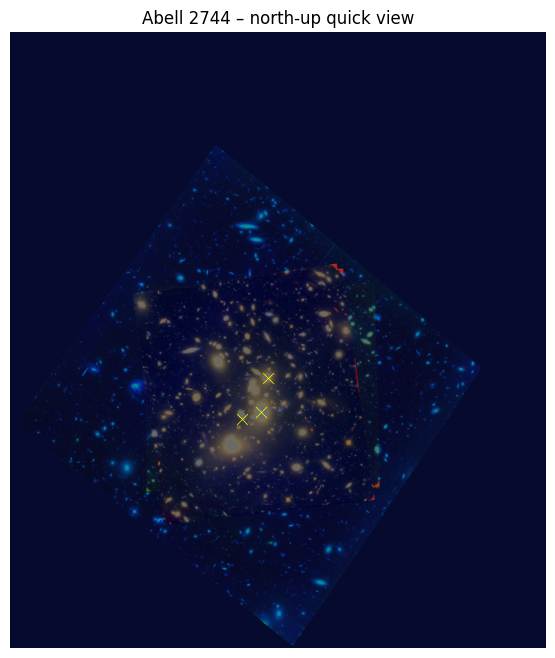

In [91]:
from scipy.ndimage import rotate
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
import astropy.units as u

wcs = WCS(fits.getheader(files['F814W']))     # any header will do
# ------------------------------------------------------------------
# 0) rgb  –  your already-made colour array (ny, nx, 3)
#    wcs  –  the *original* WCS object that rgb came from
ny, nx, _ = rgb.shape
centre = (nx / 2, ny / 2)

# ------------------------------------------------------------------
# 1) angle between the +x pixel axis and celestial East -------------
sky_c   = pixel_to_skycoord(*centre, wcs)
sky_px  = pixel_to_skycoord(centre[0] + 200, centre[1], wcs)   # 200 px to the right
pa      = sky_c.position_angle(sky_px).deg                    # PA of +x (deg E of N)

theta   = 0                # rotation angle (deg, CCW positive for scipy)
rgb_n   = rotate(rgb, theta, reshape=True, order=1)           # quick cubic = order 3

# ------------------------------------------------------------------
# 2) helper to move points -----------------------------------------
def rot_xy(x, y, theta_deg, orig_centre, new_shape):
    """
    Rotate pixel coords (x, y) by theta about orig_centre, the way
    scipy.ndimage.rotate() did, and return coords in the new array.
    """
    # 1. shift to origin
    dx, dy = x - orig_centre[0], y - orig_centre[1]

    # 2. rotate (scipy uses +CCW)
    th = np.deg2rad(theta_deg)
    xr =  dx * np.cos(th) - dy * np.sin(th)
    yr =  dx * np.sin(th) + dy * np.cos(th)

    # 3. shift back – BUT the output array has grown; its new centre is:
    ny2, nx2 = new_shape
    new_centre = (nx2 / 2, ny2 / 2)
    return xr + new_centre[0], yr + new_centre[1]

# ------------------------------------------------------------------
# 3) example: plot three sky positions -----------------------------
ra_dec  = [(3.58650, -30.4000),   # RA, Dec in deg – e.g. multiply-imaged galaxy
           (3.58520, -30.3943),
           (3.59010, -30.4012)]

# convert to original pixel coords
pix = [wcs.world_to_pixel(SkyCoord(ra, dec, unit='deg')) for ra, dec in ra_dec]

# transform them into rotated image coords
x_rot, y_rot = zip(*[rot_xy(x, y, theta, centre, rgb_n.shape[:2]) for x, y in pix])

# ------------------------------------------------------------------
# 4) display --------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_n, origin='lower')
ax.scatter(x_rot, y_rot, s=60, c='yellow', marker='x', ec='black', lw=0.5)
ax.set_title('Abell 2744 – north-up quick view')
ax.axis('off')          # grid/axes off because WCS is invalid now
plt.show()

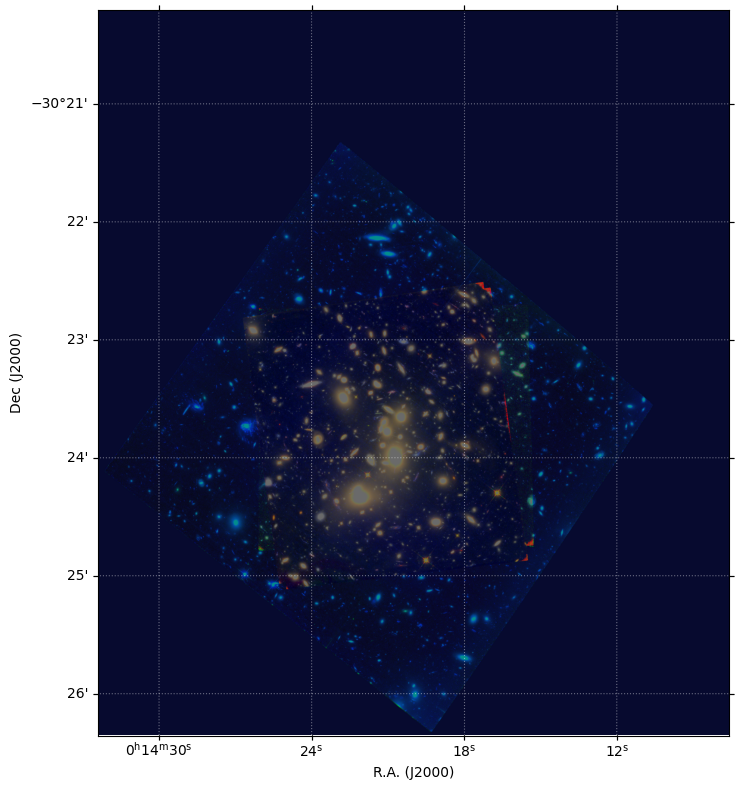

In [84]:
wcs = WCS(fits.getheader(files['F814W']))     # any header will do
fig = plt.figure(figsize=(8, 8))
ax  = plt.subplot(projection=wcs)
ax.imshow(rgb, origin='lower')
ax.coords.grid(color='white', ls='dotted', alpha=0.4)
ax.set_xlabel('R.A. (J2000)')
ax.set_ylabel('Dec (J2000)')
plt.tight_layout()
plt.show()